In [95]:
!pip install "numpy<1.24" --user

import numpy as np

In [96]:
import pandas as pd

In [97]:
import matplotlib.pyplot as plt
import geopandas as gpd

pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 40)

In [98]:
# Collecte des données

data = pd.read_csv("Donnees-sur-le-parc-de-vehicule-au-niveau-regional.2023-05.csv", sep=';',header=[1])
zones = gpd.read_file('aires.geojson')

In [99]:
possibles = []

for i in ["Crit'Air 2", "Crit'Air 3", "Crit'Air 4", "Crit'Air 5"] :
    possibles.append(("Diesel", i))
for i in ["Crit'Air 1", "Crit'Air 2", "Crit'Air 3"] :
    possibles.append(("Essence", i))
    
possibles.append(("Hybride rechargeable", "Crit'Air 1"))
possibles.append(('Electrique et hydrogène', "Crit'Air E"))

In [227]:
# Parc historique

# On se focalise sur les véhicules particuliers et les camionnettes
df1 = data.loc[(data["CATEGORIE_VEHICULE"] == "Véhicule particulier") |
                (data["CATEGORIE_VEHICULE"] == "Dérivé VP") |
                (data["CATEGORIE_VEHICULE"] == "Camionnette")]

def age_num(age) :
    res = []
    for i in range (len(age)) :
        res.append(int(str(age[i])[0:2]))
    return res

# On créé une colonne avec l'âge du véhicule sous forme numérique
df1.insert(loc = 1, column = 'AGE_NUM', value = age_num(np.array(df1['AGE'], dtype = str)))

# On peut se séparer de certaines colonnes
df1 = df1.drop(['REGION_CODE', 'REGION_LIBELLE', 'CLASSE_VEHICULE', 'STATUT_UTILISATEUR', 'AGE'], axis = 1)

# On effectue la somme pour les différentes régions et statuts d'utilisateurs
df1 = df1.groupby(['CATEGORIE_VEHICULE','CARBURANT','CRITAIR', 'AGE_NUM'], as_index = False).sum()
df1 = df1.sort_values(by = ['CATEGORIE_VEHICULE','CARBURANT','CRITAIR', 'AGE_NUM'])

In [228]:
# Il faut rajouter les lignes pour les âges de véhicule qui n'existent pas encore

for p in possibles :
    for v in ["Véhicule particulier", "Camionnette", "Dérivé VP"] :
        ages = pd.unique(df1.loc[(df1['CATEGORIE_VEHICULE'] == v) &
                                 (df1['CARBURANT'] == p[0]) &
                                 (df1['CRITAIR'] == p[1])]
                            ['AGE_NUM']
                        )
        for j in range (0, 26) :
            if j not in ages :
                res = [v, p[0], p[1], j]
                res.extend(np.zeros(12, dtype = int))
                res = pd.DataFrame([res], columns = df1.columns)
                df1 = pd.concat([df1, res], ignore_index = True)

df1 = df1.sort_values(by = ['CATEGORIE_VEHICULE','CARBURANT','CRITAIR', 'AGE_NUM'])
df1 = df1.loc[df1['CATEGORIE_VEHICULE'] == "Véhicule particulier"]
df1 = df1[df1[['CARBURANT', 'CRITAIR']].apply(tuple, axis=1).isin(possibles)]
df1 = df1.reset_index()
df1 = df1.drop(['index'], axis = 1)

In [229]:
df1.head(5)

,CATEGORIE_VEHICULE,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Véhicule particulier,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422
1,Véhicule particulier,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355
2,Véhicule particulier,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287
3,Véhicule particulier,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754
4,Véhicule particulier,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306


In [178]:
fit_pannes = pd.read_csv('fit_pannes.csv')

def f(cat_vhl, carb, crit, age) :
    res = fit_pannes.loc[(fit_pannes['CATEGORIE_VEHICULE'] == cat_vhl) &
                          (fit_pannes['CARBURANT'] == carb) &
                          (fit_pannes['CRITAIR'] == crit)][str(age)]
    return res.sum()

#print(f("Véhicule particulier", "Diesel", "Crit'Air 3", 13))
#print(np.random.binomial(2000, f("Véhicule particulier", "Diesel",
                                    #"Crit'Air 3", 13)))

In [211]:
# Fonction de pannes
# f(cat_vhl, car, critair, age_num) donne proportion de pannes moyennes

def panne_inter(row) :
    return int(np.random.binomial(row[-1], f(row['CATEGORIE_VEHICULE'], row['CARBURANT'],
                                    row['CRITAIR'], row['AGE_NUM'])))

def panne(df : pd.DataFrame) :
    df_cop = df.copy()
    df_cop['Pannes'] = df_cop.apply(panne_inter, axis = 1)
    return df_cop

# Ca marche!


In [213]:
# Nombre de véhicules neufs à rajouter, à utiliser après pannes

def nbr_vhl_neufs_fonc(df : pd.DataFrame, r) :
    col = df.columns.to_list()
    res = 0
    if not (df[col[-1]] == 0).all() :
        res = df[col[-1]].sum() 
    res += r*df[col[-2]].sum()
    return int(res)

#print(nbr_vhl_neufs_fonc(df, 0.05))

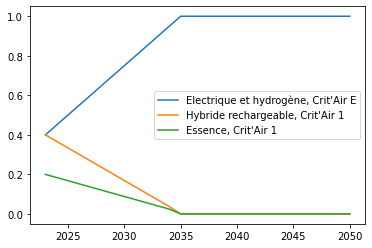

In [214]:
# Distribution des véhicules neufs

def g(carb, crit, age_num, annee) :
    if age_num != 0 :
        return 0
    if annee < 2035 :
        if crit == "Crit'Air E" and carb == "Electrique et hydrogène" :
            return 0.4 + (annee - 2023)*0.05
        if crit == "Crit'Air 1" and carb == "Hybride rechargeable" :
            return 0.4 - (annee - 2023)*0.033
        if crit == "Crit'Air 1" and carb == "Essence" :
            return 0.2 - (annee - 2023)*0.016
        else : return 0
    else :
        if crit == "Crit'Air E" and carb == "Electrique et hydrogène" :
            return 1
        else : return 0

x = np.arange(2023, 2051, 1)
y = [[],[],[]]

for i in range (len(x)) :
    y[0].append(g("Electrique et hydrogène", "Crit'Air E", 0, x[i]))
    y[1].append(g("Hybride rechargeable", "Crit'Air 1", 0, x[i]))
    y[2].append(g("Essence", "Crit'Air 1", 0, x[i]))

plt.plot(x, y[0], label = "Electrique et hydrogène, Crit'Air E")
plt.plot(x, y[1], label = "Hybride rechargeable, Crit'Air 1")
plt.plot(x, y[2], label = "Essence, Crit'Air 1")

plt.legend(loc="center right")
plt.show()

In [215]:
def approx_binomial(n, p) :
    return np.random.normal(n*p, np.sqrt(n*p*(1-p)))

def neufs_inter(row, nbr_vhl_neufs, annee) :
    return (approx_binomial(nbr_vhl_neufs, g(row['CARBURANT'],
                                             row['CRITAIR'], row['AGE_NUM'], annee)))

def vhl_neufs(df : pd.DataFrame, n, a) :
    df_cop = df.copy()
    df_cop['Neufs'] = df_cop.apply(neufs_inter, nbr_vhl_neufs = n, annee = a, axis = 1)
    return df_cop

# g est la fonction qui donne les proportions de tel ou tel type de véhicule dans les véhicules neufs
# Elle renvoie 0 pour les lignes où l'âge du véhicule est supérieur à 0
        

In [260]:
def final(df_arg : pd.DataFrame, annee) :
    df = df_arg.copy()
    # Dans un premier temps, on remet les +25 qui sont pas en pannes
    df['25_plus'] = pd.DataFrame(np.transpose(np.zeros(len(df))))
    idx = df.loc[df['AGE_NUM'] == 25].index
    df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]

    # Ensuite, on fait shifter toutes les colonnes qui ne sont pas +25, en sommant sur la colonne créée au-dessus
    df[str(annee)] = pd.DataFrame(np.transpose(np.zeros(len(df))))
    idx_2 = df.loc[df['AGE_NUM'] != 25].index
    idx_3 = df.loc[df['AGE_NUM'] != 0].index
    df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
    df[str(annee)][idx] = df['25_plus'][idx] + df[df.columns.to_list()[-5]].shift(periods = 1, axis = 0)[idx]

    # Ne pas oublier de rajouter les neufs
    df[str(annee)] += df['Neufs']

    return df

df2 = panne(df1)
df2 = vhl_neufs(df2, nbr_vhl_neufs_fonc(df2, 0.005), 2023)
df2 = final(df2, 2023)
df2.tail(30)


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

,CATEGORIE_VEHICULE,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,Pannes,Neufs,25_plus,2023
204,Véhicule particulier,Essence,Crit'Air 3,22,0,0,0,0,0,6,13,424,8595,208377,270500,322035,40263,0.000000,0.0,312518.000000
205,Véhicule particulier,Essence,Crit'Air 3,23,0,0,0,0,0,0,7,12,359,7118,173336,235609,31179,0.000000,0.0,281772.000000
206,Véhicule particulier,Essence,Crit'Air 3,24,0,0,0,0,0,0,0,7,13,313,6169,147708,20979,0.000000,0.0,204430.000000
207,Véhicule particulier,Essence,Crit'Air 3,25,0,0,0,0,0,0,0,0,7,18,292,5717,874,0.000000,4843.0,152551.000000
208,Véhicule particulier,Hybride rechargeable,Crit'Air 1,0,6458,8799,3533,821,1982,5740,7548,11823,14469,18386,74288,140561,0,878317.574156,0.0,878317.574156
209,Véhicule particulier,Hybride rechargeable,Crit'Air 1,1,5480,6406,8654,3452,715,1826,5387,7421,11890,14435,18011,75359,0,0.000000,0.0,140561.000000
210,Véhicule particulier,Hybride rechargeable,Crit'Air 1,2,2460,5450,6351,8568,3435,699,1810,5323,7357,11917,14631,18870,0,0.000000,0.0,75359.000000
211,Véhicule particulier,Hybride rechargeable,Crit'Air 1,3,1476,2453,5376,6234,8524,3344,678,1809,5246,7033,11601,14549,0,0.000000,0.0,18870.000000
212,Véhicule particulier,Hybride rechargeable,Crit'Air 1,4,1154,1423,2238,5050,5826,8002,3050,599,1658,4783,6552,11195,0,0.000000,0.0,14549.000000
213,Véhicule particulier,Hybride rechargeable,Crit'Air 1,5,434,1208,1512,2243,5100,5838,7970,3086,632,1680,4960,6838,0,0.000000,0.0,11195.000000


In [233]:
# Ne pas oublier de drop les colonnes 'Pannes', 'Neufs' et '25_plus'

In [234]:
df1.head(5)

,CATEGORIE_VEHICULE,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022
0,Véhicule particulier,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422
1,Véhicule particulier,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355
2,Véhicule particulier,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287
3,Véhicule particulier,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754
4,Véhicule particulier,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306


In [261]:
df_mod = df1.copy()

for a in range(2023, 2051) :
    df_mod = panne(df_mod)
    df_mod = vhl_neufs(df_mod, nbr_vhl_neufs_fonc(df_mod, 0.05), a)
    df_mod = final(df_mod, a)
    df_mod = df_mod.drop(['Pannes', 'Neufs', '25_plus'], axis = 1)

df_mod.head(5)

<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64
0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64
0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64
0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64
0           0.0
1      366422.0
2      560355.0
3      819287.0
4      890754.0
         ...   
229         1.0
230         0.0
231         0.0
232         0.0
233         0.0
Name: 2023, Length: 234, dtype: float64


<ipython-input-260-0af6bca8fdc3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['25_plus'][idx] = df[df.columns.to_list()[-4]][idx] - df['Pannes'][idx]
<ipython-input-260-0af6bca8fdc3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str(annee)][idx_3] += (df[df.columns.to_list()[-5]][idx_2] - df['Pannes'][idx_2]).shift(periods = 1, axis = 0)
<ipython-input-260-0af6bca8fdc3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df

,CATEGORIE_VEHICULE,CARBURANT,CRITAIR,AGE_NUM,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,2023,2024,2025,2026,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Véhicule particulier,Diesel,Crit'Air 2,0,613931,1523925,1386877,1216452,1169300,1112126,1059557,993562,846449,759822,527529,366422,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Véhicule particulier,Diesel,Crit'Air 2,1,202067,635256,1596408,1464999,1286269,1214764,1145725,1086359,1020107,881997,796788,560355,366422.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Véhicule particulier,Diesel,Crit'Air 2,2,11260,206200,647651,1628838,1491741,1299481,1228160,1156419,1112068,1060189,900584,819287,560355.0,366422.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Véhicule particulier,Diesel,Crit'Air 2,3,4,11623,204669,640177,1606051,1468861,1277658,1194521,1133315,1099322,1047653,890754,819287.0,560355.0,366422.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Véhicule particulier,Diesel,Crit'Air 2,4,2,1,12184,196210,612145,1535359,1400228,1209525,1128641,1081761,1046898,982306,890754.0,819287.0,560355.0,366422.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [273]:
df_y = df_mod.drop(['AGE_NUM'], axis = 1)
df_y = df_y.groupby(['CATEGORIE_VEHICULE', 'CARBURANT', 'CRITAIR'], as_index = False).sum()
df_y.head(10)

,CATEGORIE_VEHICULE,CARBURANT,CRITAIR,PARC_2011,PARC_2012,PARC_2013,PARC_2014,PARC_2015,PARC_2016,PARC_2017,PARC_2018,PARC_2019,PARC_2020,PARC_2021,PARC_2022,2023,2024,2025,2026,2027,...,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050
0,Véhicule particulier,Diesel,Crit'Air 2,827265,2377008,3847792,5159016,6373024,7446200,8448397,9334636,10092595,10834684,11296179,11518003,1.148757e+07,1.138236e+07,1.114292e+07,1.073090e+07,1.013583e+07,...,6.439564e+06,5.389621e+06,4.367918e+06,3.409944e+06,2.551288e+06,1.821908e+06,1.237425e+06,7.937650e+05,4.788780e+05,2.693330e+05,1.408010e+05,6.791000e+04,3.055300e+04,1.283100e+04,5.372000e+03,2.294000e+03,1.079000e+03,2.330000e+02,5.100000e+01,1.400000e+01
1,Véhicule particulier,Diesel,Crit'Air 3,7742704,7760899,7661174,7578691,7508905,7436490,7308735,7124372,6860385,6607215,6312533,5979327,5.345898e+06,4.605801e+06,3.820277e+06,3.045860e+06,2.330781e+06,...,5.158570e+05,3.256040e+05,2.009280e+05,1.237160e+05,7.608600e+04,4.628100e+04,2.263400e+04,1.074800e+04,5.098000e+03,2.415000e+03,1.136000e+03,5.290000e+02,2.390000e+02,1.210000e+02,5.600000e+01,1.800000e+01,1.000000e+01,5.000000e+00,2.000000e+00,1.000000e+00
2,Véhicule particulier,Diesel,Crit'Air 4,5846552,5728183,5612884,5476665,5331907,5141115,4897300,4591724,4166627,3669834,3231905,2862703,2.186967e+06,1.607439e+06,1.135674e+06,7.736910e+05,5.286100e+05,...,9.787700e+04,5.393100e+04,2.893800e+04,1.539700e+04,8.303000e+03,4.472000e+03,2.297000e+03,1.249000e+03,6.530000e+02,3.580000e+02,1.870000e+02,1.040000e+02,5.500000e+01,2.900000e+01,1.600000e+01,1.000000e+01,8.000000e+00,5.000000e+00,2.000000e+00,2.000000e+00
3,Véhicule particulier,Diesel,Crit'Air 5,2353317,2257289,2145065,2016424,1880408,1729314,1562729,1390436,1184213,959625,771784,653626,5.681950e+05,4.959740e+05,4.392910e+05,3.904150e+05,3.274820e+05,...,1.592500e+05,1.329790e+05,1.108760e+05,9.247800e+04,7.715500e+04,6.442900e+04,5.368500e+04,4.502100e+04,3.763900e+04,3.144100e+04,2.632000e+04,2.198600e+04,1.834300e+04,1.530100e+04,1.284500e+04,1.074000e+04,8.940000e+03,7.478000e+03,6.250000e+03,5.198000e+03
4,Véhicule particulier,Electrique et hydrogène,Crit'Air E,1256,3725,8771,16484,25320,41329,60908,82227,106439,141498,245281,403010,1.934698e+06,3.774147e+06,5.941105e+06,8.450788e+06,1.131644e+07,...,2.649786e+07,3.115772e+07,3.606694e+07,4.122307e+07,4.673119e+07,5.240179e+07,5.829274e+07,6.441416e+07,7.073590e+07,7.721053e+07,8.377957e+07,9.040863e+07,9.707713e+07,1.037776e+08,1.105070e+08,1.172605e+08,1.240565e+08,1.309488e+08,1.379695e+08,1.451781e+08
5,Véhicule particulier,Essence,Crit'Air 1,336021,910749,1409943,1960319,2565414,3313130,4213367,5255558,6508307,7853625,8746597,9487099,1.008120e+07,1.058941e+07,1.099988e+07,1.130304e+07,1.147572e+07,...,1.038900e+07,9.702986e+06,8.962069e+06,8.167937e+06,7.272143e+06,6.416741e+06,5.602207e+06,4.829560e+06,4.102409e+06,3.422305e+06,2.794330e+06,2.223402e+06,1.715257e+06,1.275928e+06,9.103776e+05,6.302706e+05,4.233636e+05,2.751856e+05,1.732796e+05,1.054866e+05
6,Véhicule particulier,Essence,Crit'Air 2,2952779,2929628,2893449,2856940,2833479,2815089,2782452,2742739,2684999,2639277,2579829,2505199,2.390304e+06,2.246739e+06,2.081182e+06,1.899371e+06,1.708681e+06,...,9.655600e+05,8.257770e+05,6.978820e+05,5.823150e+05,4.898420e+05,4.005910e+05,3.151960e+05,2.477290e+05,1.946650e+05,1.528250e+05,1.198740e+05,9.399100e+04,7.385100e+04,5.809800e+04,4.568300e+04,3.583500e+04,2.818600e+04,2.217700e+04,1.735600e+04,1.362200e+04
7,Véhicule particulier,Essence,Crit'Air 3,5400983,5224607,5040386,4850634,4668418,4467292,4235181,3985278,3675165,3327339,2968045,2672601,2.410263e+06,2.164488e+06,1.936019e+06,1.720038e+06,1.517336e+06,...,8.781160e+05,7.472100e+05,6.354780e+05,5.397480e+05,4.587340e+05,3.902590e+05,3.317690e+05,2.818150e+05,2.397490e+05,2.043550e+05,1.737500e+05,1.481000e+05,1.258780e+05,1.072240e+05,9.138200e+04,7.787600e+04,6.615600e+04,5.641500e+04,4.804000e+04,4.0

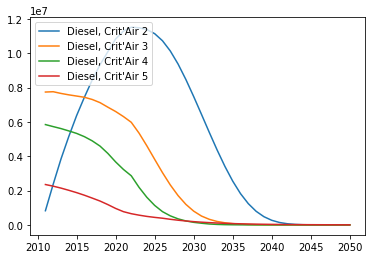

In [275]:
x = np.arange(2011, 2051, 1)

for i in range (0, 4) :
    v = df_y.iloc[i]
    y = np.array(v[3:])
    plt.plot(x, y, label = str(v[1]) + ", " + str(v[2]))

plt.legend(loc = "upper left")
plt.show()


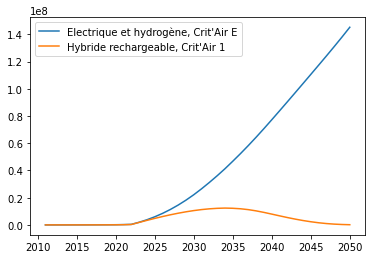

In [280]:
for i in [4, 8] :
    v = df_y.iloc[i]
    y = np.array(v[3:])
    plt.plot(x, y, label = str(v[1]) + ", " + str(v[2]))

plt.legend(loc = "upper left")
plt.show()

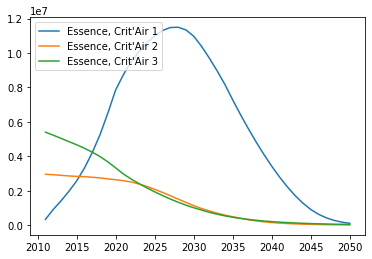

In [282]:
for i in range(5, 8) :
    v = df_y.iloc[i]
    y = np.array(v[3:])
    plt.plot(x, y, label = str(v[1]) + ", " + str(v[2]))

plt.legend(loc = "upper left")
plt.show()